In [1]:
import gmsh
import numpy as np
import jax.numpy as jnp
from dctkit.mesh import util, simplex
from dctkit.math.opt import optctrl
from dctkit.apps.linear_elasticity import LinearElasticity
import dctkit.dec.cochain as C
import dctkit as dt
from matplotlib.pyplot import triplot

In [2]:
dt.config()

In [3]:
# load and define the simplicial complex
lc = 0.5
_, _, S_2, node_coords, bnd_faces_tags = util.generate_square_mesh(lc)
bnodes, _ = gmsh.model.mesh.getNodesForPhysicalGroup(1, 1)
bnodes -= 1
bnodes = bnodes.astype(dt.int_dtype)
S = simplex.SimplicialComplex(
    S_2, node_coords, bnd_faces_tags=bnd_faces_tags, is_well_centered=True)
S.get_circumcenters()
S.get_primal_volumes()
S.get_dual_volumes()
S.get_hodge_star()
S.get_dual_edge_vectors()
S.get_flat_weights()

Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 30%] Meshing curve 2 (Line)
Info    : [ 50%] Meshing curve 3 (Line)
Info    : [ 80%] Meshing curve 4 (Line)
Info    : Done meshing 1D (Wall 0.000241946s, CPU 0.000155s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.000344384s, CPU 0.000194s)
Info    : 12 nodes 26 elements


In [4]:
bnd_edges_idx = S.bnd_faces_indices
left_bnd_nodes_idx, _ = util.get_nodes_from_physical_group(1, 2)
right_bnd_nodes_idx, _ = util.get_nodes_from_physical_group(1, 3)
left_bnd_edges_idx = util.get_belonging_elements(dim=1, tag=2, nodeTagsPerElem=S.S[1])
right_bnd_edges_idx = util.get_belonging_elements(dim=1, tag=4, nodeTagsPerElem=S.S[1])

# conversion to lists makes concatenation easier when assigning bcs
left_bnd_nodes_idx = list(left_bnd_nodes_idx)
right_bnd_nodes_idx = list(right_bnd_nodes_idx)
bottom_left_corner = left_bnd_nodes_idx.pop(0)

In [5]:
# UNIAXIAL TENSION TEST: prescribe horizontal displacement of the right-end nodes and fix that of the left-hand nodes.
# All the other edges are traction-free.

# Dirichlet bcs
applied_strain = 0.02
left_bnd_pos_components = [0]
right_bnd_pos_components = [0]
left_bnd_nodes_pos = S.node_coord[left_bnd_nodes_idx, :][:, left_bnd_pos_components]
right_bnd_nodes_pos = S.node_coord[right_bnd_nodes_idx, :][:, right_bnd_pos_components]*(1.+applied_strain)
bottom_left_corner_pos = S.node_coord[bottom_left_corner, :]
print(right_bnd_nodes_pos)

# NOTE: without flatten it does not work properly when concatenating multiple bcs; 
# fix this so that flatten is not needed (not intuitive)
boundary_values = {"0": (left_bnd_nodes_idx + right_bnd_nodes_idx, 
                         np.vstack((left_bnd_nodes_pos, right_bnd_nodes_pos)).flatten()),
                    ":": (bottom_left_corner, bottom_left_corner_pos)}
print(boundary_values)

# traction bcs - TO IMPROVE: allow to specify components of the traction, as for the positions
idx_free_edges = list(set(bnd_edges_idx) - set(right_bnd_edges_idx) - set(left_bnd_edges_idx))
bnd_tractions_free_values = np.zeros((len(idx_free_edges), 2), dtype=dt.float_dtype)
boundary_tractions = {':': (idx_free_edges, bnd_tractions_free_values)}
print(boundary_tractions)

[[1.02]
 [1.02]
 [1.02]]
{'0': ([3, 5, 0, 2, 7], array([0.  , 0.  , 1.02, 1.02, 1.02])), ':': (1, array([0., 0., 0.]))}
{':': ([0, 10, 3, 6], array([[0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.]]))}


In [6]:
mu_ = 1.
lambda_ = 10.
ni = lambda_/(2*(mu_ + lambda_))
E = mu_*(3*lambda_+2*mu_)/(mu_+lambda_)
ela = LinearElasticity(S=S, mu_=mu_, lambda_=lambda_)
gamma = 1000.

In [7]:
# body force
num_faces = S.S[2].shape[0]
embedded_dim = S.embedded_dim
f = np.zeros((num_faces, (embedded_dim-1)))

true_strain_yy = -(lambda_/(2*mu_+lambda_))*applied_strain # plane-strain, sigma_yy = 0
true_stress_xx = (2*mu_+lambda_)*applied_strain + lambda_*true_strain_yy
print("Expected stress xx component = ", true_stress_xx)
print("Expected strain xx component = ", applied_strain)
print("Expected strain yy component = ", true_strain_yy) 

f_flattened = f.flatten()
node_coords_flattened = S.node_coord.flatten()

obj_args = {'f': f_flattened, 'gamma': gamma, 'boundary_values': boundary_values, 
            'boundary_tractions': boundary_tractions}

prb = optctrl.OptimizationProblem(dim=S.node_coord.size,
                                  state_dim=S.node_coord.size,
                                  objfun=ela.obj_linear_elasticity)

Expected stress xx component =  0.07333333333333333
Expected strain xx component =  0.02
Expected strain yy component =  -0.016666666666666666


In [8]:
prb.set_obj_args(obj_args)
sol = prb.run(x0=node_coords_flattened)
curr_node_coords = sol.reshape(S.node_coord.shape)
print(prb.last_opt_result)

3


In [9]:
strain = ela.get_strain(curr_node_coords)
stress = ela.get_stress(strain)

print("strain=", strain)
print("stress=", stress)

strain= [[[ 2.02003995e-02  7.15837606e-07]
  [ 7.15837606e-07 -1.68340107e-02]]

 [[ 2.02010088e-02  1.43140583e-06]
  [ 1.43140583e-06 -1.68340479e-02]]

 [[ 2.02034103e-02  1.60794033e-06]
  [ 1.60794033e-06 -1.68368025e-02]]

 [[ 2.01968990e-02  5.05068444e-07]
  [ 5.05068444e-07 -1.68300003e-02]]

 [[ 2.02023521e-02  1.84188100e-06]
  [ 1.84188100e-06 -1.68361409e-02]]

 [[ 2.01996096e-02  2.00762205e-06]
  [ 2.00762205e-06 -1.68330668e-02]]

 [[ 2.01974435e-02  1.31288822e-07]
  [ 1.31288822e-07 -1.68308483e-02]]

 [[ 2.01989954e-02  3.77959389e-07]
  [ 3.77959389e-07 -1.68319069e-02]]

 [[ 2.02005652e-02  1.72881183e-06]
  [ 1.72881183e-06 -1.68332112e-02]]

 [[ 2.01988388e-02  1.67178895e-06]
  [ 1.67178895e-06 -1.68336465e-02]]

 [[ 2.01986132e-02  1.54824383e-06]
  [ 1.54824383e-06 -1.68309053e-02]]

 [[ 2.02030928e-02  1.27905180e-06]
  [ 1.27905180e-06 -1.68359179e-02]]

 [[ 2.02009458e-02  2.52010408e-06]
  [ 2.52010408e-06 -1.68350813e-02]]

 [[ 2.01971087e-02  5.02829468

In [10]:
exact_stress = np.array([[true_stress_xx, 0.],[0.,0.]])
exact_strain = np.array([[applied_strain, 0.], [0., true_strain_yy]])
mean_stress = np.mean(stress, axis=0)
std_stress = np.std(stress,axis=0)
std_strain = np.std(strain,axis=0)
mean_strain = np.mean(strain, axis=0)
print(mean_stress) 
print(exact_stress)
print(mean_strain)
print(exact_strain)

[[ 7.40659465e-02  2.55283335e-06]
 [ 2.55283335e-06 -6.38780714e-07]]
[[0.07333333 0.        ]
 [0.         0.        ]]
[[ 2.01999488e-02  1.27641667e-06]
 [ 1.27641667e-06 -1.68333439e-02]]
[[ 0.02        0.        ]
 [ 0.         -0.01666667]]


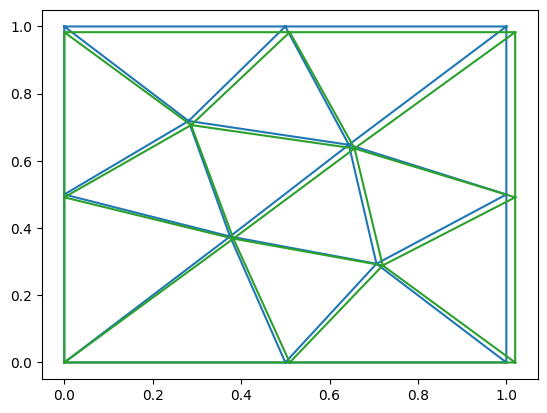

In [11]:
triplot(node_coords[:,0], node_coords[:,1], triangles=S_2)
triplot(curr_node_coords[:,0], curr_node_coords[:,1], triangles=S_2)